In [89]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
import re
from ucimlrepo import fetch_ucirepo
import warnings

warnings.filterwarnings('ignore')


In [90]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [91]:
import train_tabular_utils as tt
import cv_split_utils
import enums
import data_utils

In [92]:
class Config:
    RUN_MODE = "LOCAL"
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    TARGET_COL_NAME = "Target"        
    SCALER = enums.Scaler.StandardScaler
    METRIC = enums.Metrics.ACCURACY
    # These values are more dynamic   
    MODEL_TYPE = enums.ModelName.RandomForest
    NUM_TUNING_TRIALS = 2
    TUNE_ON_SINGLE_FOLD = True
    TRAIN_SINGLE_FOLD = True    
    PERSIST_MODEL = False
    USE_OPENFE_FEATURES = False
    CREATE_MANUAL_FEATURES = True
    USE_ORIGINAL_DATA = True

COLS_TO_LEAVE = ["id", "Target", "kfold"]
CPU_COUNT = os.cpu_count()

DATA_READPATH = "./data/"
DATA_WRITEPATH = "./output/"
SUBMISSION_FILEPATH = DATA_READPATH
if Config.RUN_MODE == "KAGGLE":    
    DATA_READPATH = "/kaggle/input/playground-series-s4e6/"
    SUBMISSION_FILEPATH = "/kaggle/input/playground-series-s4e6/"
    DATA_WRITEPATH = "/kaggle/working/"

In [93]:
# fetch original dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
df_train_orig = predict_students_dropout_and_academic_success.data.features 
df_train_orig[Config.TARGET_COL_NAME] = predict_students_dropout_and_academic_success.data.targets[Config.TARGET_COL_NAME]
# rename column 'Marital Status' to 'Marital status'
df_train_orig = df_train_orig.rename(columns={'Marital Status': 'Marital status'})

In [94]:
# no missing values in original data
na_orig = df_train_orig.isna().sum()
na_orig.loc[na_orig > 0]

Series([], dtype: int64)

In [95]:
if Config.USE_OPENFE_FEATURES:    
    df_train = pd.read_csv(DATA_READPATH + "train_openfe.csv")    
    df_test = pd.read_csv(DATA_READPATH + "test_openfe.csv")
else:    
    df_train = pd.read_csv(DATA_READPATH + "train.csv")
    df_train = df_train.drop("id", axis=1)    
    df_test = pd.read_csv(DATA_READPATH + "test.csv")
    df_test = df_test.drop("id", axis=1)
    if Config.USE_ORIGINAL_DATA:
        # add df_train_orig rows to df_train
        df_train = pd.concat([df_train, df_train_orig], axis=0, ignore_index=True)

In [96]:
# Label encoding of target values
le = LabelEncoder()
le.fit(df_train[Config.TARGET_COL_NAME])
df_train[Config.TARGET_COL_NAME] = le.transform(df_train[Config.TARGET_COL_NAME])
list(le.classes_)

['Dropout', 'Enrolled', 'Graduate']

In [97]:
def process_col_name(cols_list):
    processed_cols_list = []
    for item in cols_list:
        # Remove round brackets but keep the text inside them
        item_no_brackets = re.sub(r'[\(\)]', '', item)
        # Remove single quotes
        item_no_quotes = item_no_brackets.replace("'", "")
        # Replace spaces with underscores
        item_processed = item_no_quotes.replace(' ', '_')
        # Append to the processed list
        processed_cols_list.append(item_processed)
    return processed_cols_list

In [98]:
train_cols_list = df_train.columns.to_list()
test_cols_list = df_test.columns.to_list()
train_processed_cols_list = process_col_name(train_cols_list)
test_processed_cols_list = process_col_name(test_cols_list)
df_train.columns = train_processed_cols_list
df_test.columns = test_processed_cols_list

In [99]:
# feature engineering
def create_features(df):
    # (Tuition_fees_up_to_date*Curricular_units_2nd_sem_approved)
    df["f_1"] = df["Tuition_fees_up_to_date"] * df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_1st_sem_approved+Curricular_units_2nd_sem_approved)
    df["f_2"] = df["Curricular_units_1st_sem_approved"] + df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade*Curricular_units_2nd_sem_approved)
    df["f_3"] = df["Curricular_units_2nd_sem_grade"] * df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade+Curricular_units_2nd_sem_approved)
    df["f_4"] = df["Curricular_units_2nd_sem_grade"] + df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade+Scholarship_holder)
    df["f_5"] = df["Curricular_units_2nd_sem_grade"] + df["Scholarship_holder"]
    # (Curricular_units_1st_sem_grade+Scholarship_holder)
    df["f_6"] = df["Curricular_units_1st_sem_grade"] + df["Scholarship_holder"]
    # (Curricular_units_2nd_sem_enrolled-Curricular_units_2nd_sem_approved)
    df["f_7"] = df["Curricular_units_2nd_sem_enrolled"] - df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_1st_sem_enrolled-Curricular_units_2nd_sem_approved)
    df["f_8"] = df["Curricular_units_1st_sem_enrolled"] - df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade-Curricular_units_1st_sem_evaluations)
    df["f_9"] = df["Curricular_units_2nd_sem_grade"] - df["Curricular_units_1st_sem_evaluations"]
    # (Curricular_units_1st_sem_grade/Age_at_enrollment)
    df["f_10"] = df["Curricular_units_1st_sem_grade"] / df["Age_at_enrollment"]
    # (Curricular_units_1st_sem_evaluations-Curricular_units_2nd_sem_approved)
    df["f_11"] = df["Curricular_units_1st_sem_evaluations"] - df["Curricular_units_2nd_sem_approved"]
    # GroupByThenRank(Curricular_units_2nd_sem_approved,Curricular_units_1st_sem_enrolled)    
    df["f_12"] = df.groupby('Curricular_units_1st_sem_enrolled')['Curricular_units_2nd_sem_approved'].rank(method="dense", ascending=False)
    # GroupByThenRank(Curricular_units_2nd_sem_approved,Mothers_occupation)
    df["f_13"] = df.groupby('Mothers_occupation')['Curricular_units_2nd_sem_approved'].rank(method="dense", ascending=False)
    # GroupByThenRank(Scholarship_holder,Age_at_enrollment)
    df["f_14"] = df.groupby('Age_at_enrollment')['Scholarship_holder'].rank(method="dense", ascending=False)
    # GroupByThenRank(Scholarship_holder,Curricular_units_2nd_sem_approved)
    df["f_15"] = df.groupby('Curricular_units_2nd_sem_approved')['Scholarship_holder'].rank(method="dense", ascending=False)
    # CombineThenFreq(Course,Curricular_units_1st_sem_approved)
    df["f_16"] = df.groupby('Course')['Curricular_units_1st_sem_approved'].transform('count')
    return df

In [100]:
if Config.CREATE_MANUAL_FEATURES:
    df_train = create_features(df_train)
    df_test = create_features(df_test)

In [101]:
na_val = df_train.isna().sum()
null_features = na_val.loc[na_val > 0].index.values.tolist()
null_features

[]

In [102]:
cat_features = ['Marital_status', 'Application_mode', 'Course', 'Daytime/evening_attendance', 'Previous_qualification',
    'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Displaced',
    'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date','Gender', 'Scholarship_holder', 'International']

In [103]:
cont_features = [x for x in df_train.dtypes[df_train.dtypes == "float"].index.values if x not in null_features]
int_features = df_train.dtypes[df_train.dtypes == "int"].index.values
feature_cols = df_test.columns.to_list()
feature_cols_after_fe = [x for x in df_train.columns if x not in COLS_TO_LEAVE+null_features]

In [104]:
print(feature_cols_after_fe)

['Marital_status', 'Application_mode', 'Application_order', 'Course', 'Daytime/evening_attendance', 'Previous_qualification', 'Previous_qualification_grade', 'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Admission_grade', 'Displaced', 'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'Age_at_enrollment', 'International', 'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_credited', 'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade', 'Curricular_units_2nd_sem_without_evaluations', 'Unemployment_rate', 'Inflation_rate', 'GDP', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8

In [105]:
scaler = StandardScaler()
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[                
        ("scaler", scaler, cont_features),
        #("onehot", onehot_encoder, cat_features),                
    ], remainder="passthrough"
)
#preprocessor = None

In [106]:
model_params = {'n_estimators': 703, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 4, 
                'max_features': 'log2', 'random_state': Config.RANDOM_SEED}
#model_params = None

In [107]:
df_train = cv_split_utils.strat_kfold_dataframe(df_train, 
                                                target_col_name=Config.TARGET_COL_NAME, 
                                                random_state=Config.RANDOM_SEED, 
                                                num_folds=Config.NUM_FOLDS)

In [108]:
%%time
fold_metrics_model, df_oof_preds, preprocessor = tt.train_and_validate(
        model_name=Config.MODEL_TYPE,
        model_params=model_params,
        preprocessor=preprocessor,
        df=df_train,
        feature_cols=feature_cols_after_fe,
        target_col_name=Config.TARGET_COL_NAME,
        metric=Config.METRIC,
        single_fold=Config.TRAIN_SINGLE_FOLD,
        num_folds=Config.NUM_FOLDS,
        suppress_print=False
)

Fold 0 - RandomForest - ACCURACY : 0.8245722404101551
RandomForest metric=ACCURACY CV score = 0.8245722404101551
RandomForest Mean ACCURACY = 0.8245722404101551, std = 0.0
CPU times: user 40 s, sys: 78.5 ms, total: 40.1 s
Wall time: 40.1 s


In [109]:
features = preprocessor.get_feature_names_out()
# features = feature_cols_after_fe
len(features)

52

In [110]:
# Define a function to extract the part after '__' (vectorized for speed)
def extract_after_delimiter(text):
  return text.split("__", 1)[1] if len(text.split("__")) > 1 else text

# Apply the function to the feature names using lambda
features = list(map(extract_after_delimiter, features))

In [127]:
model = fold_metrics_model[0][1]
df_feature_imp = pd.DataFrame()
df_feature_imp["f_name"] = features
df_feature_imp["f_imp"] = model.feature_importances_
df_feature_imp = df_feature_imp.sort_values(by="f_imp", ascending=False)

In [112]:
#df_feature_imp.to_csv(DATA_WRITEPATH + "rf_feature_imp_openfe_standardscalerfloat.csv", index=False)

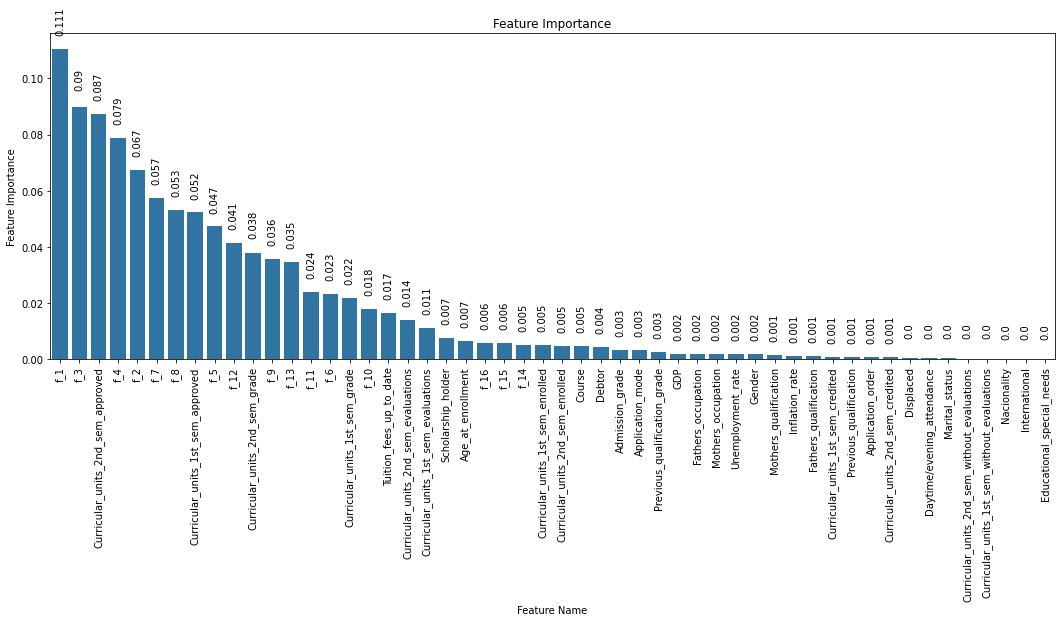

In [113]:
# Set the figure size
plt.figure(figsize=(18, 6))
# Create the bar plot
sns.barplot(x="f_name", y="f_imp", data=df_feature_imp)
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
# Add feature importance values on top of each bar (adjusted positioning)
for bar in plt.gca().containers[0]:
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, round(bar.get_height(), 3), 
           ha='center', va='center', rotation=90)  # Adjust vertical offset
# Customize plot title and labels (optional)
plt.title("Feature Importance")
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance")
# Show the plot
#plt.tight_layout()
plt.show()

In [114]:
# from sklearn.ensemble import RandomForestClassifier

# fs_model = RandomForestClassifier(**model_params)
# sfs = SequentialFeatureSelector(model, n_features_to_select=50, scoring="accuracy")
# sfs.fit(df_train[feature_cols_after_fe], df_train[Config.TARGET_COL_NAME])

In [120]:
# # select top 150 rows from df_feature_imp
# df_feature_imp = df_feature_imp.head(44)
# feature_cols_new = df_feature_imp.f_name.values

In [124]:
# cont_features1 = [x for x in df_train[feature_cols_new].dtypes[df_train.dtypes == "float"].index.values if x not in null_features]
# scaler1 = StandardScaler()
# onehot_encoder1 = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
# preprocessor1 = ColumnTransformer(
#     transformers=[                
#         ("scaler", scaler1, cont_features1),
#         #("onehot", onehot_encoder, cat_features),                
#     ], remainder="passthrough"
# )

In [125]:
# fold_metrics_model1, df_oof_preds, preprocessor = tt.train_and_validate(
#         model_name=Config.MODEL_TYPE,
#         model_params=model_params,
#         preprocessor=preprocessor1,
#         df=df_train,
#         feature_cols=feature_cols_new,
#         target_col_name=Config.TARGET_COL_NAME,
#         metric=Config.METRIC,
#         single_fold=Config.TRAIN_SINGLE_FOLD,
#         num_folds=Config.NUM_FOLDS,
#         suppress_print=False
# )

Fold 0 - RandomForest - ACCURACY : 0.8245104700722713
RandomForest metric=ACCURACY CV score = 0.8245104700722713
RandomForest Mean ACCURACY = 0.8245104700722713, std = 0.0


In [126]:
# tt.persist(
#         model_name=Config.MODEL_TYPE, 
#         fold_metrics_model=fold_metrics_model, 
#         df_oof_preds=df_oof_preds, 
#         persist_model=Config.PERSIST_MODEL, 
#         output_path=DATA_WRITEPATH
# )